# HW11: Clustering Business in NYC
## Clustering time series trends in businesses

## Data 

**Business Census data** was downloaded from the link :

http://census.gov/programs-surveys/cbp/data/datasets.html

for years 1994 to 2014

** NYC Zipcode Shapefile ** 

http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981

In [1]:
import pandas as pd
import numpy as np
import zipfile as Zipfile
import geopandas as gp
import glob
import json
import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from descartes import PolygonPatch
import pylab as pl
import sklearn.cluster
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import os
import scipy 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/shalmali/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Download required data and prep

NYC Zipcode shapefile was dowanloaded and read using Geopandas. 

In [2]:
# Define environment variable PUIDATA to variable PUIDATA
PUIDATA = os.getenv('PUIDATA')

In [3]:
fname = PUIDATA + '/nyc-zip-code-tabulation-areas-polygons.geojson'
nyc_shape = gp.read_file(fname).drop_duplicates(subset='postalCode')
# nyc_shape.plot(figsize=(5,5))  
nyczips = nyc_shape.postalCode.values.astype(int)
print ("number of NYC zip codes:", len(nyczips))   # Validating the number of zipcodes in NYC.

number of NYC zip codes: 247


In [4]:
#dropping coloumns not in need
nyc_shape.drop([  u'@id', u'BLDGpostalCode', u'ST_FIPS', u'STATE',   u'PO_NAME', u'CTY_FIPS',
             u'OBJECTID', u'Shape_Area', u'Shape_Leng'], axis = 1, inplace = True) 

#renaming the name postalcode with zip 
nyc_shape = nyc_shape.rename(columns={'postalCode' : 'zip'}) 

# convert the zip to numeric format.
nyc_shape['zip'] = pd.to_numeric(nyc_shape['zip'])
nyc_shape.head()

borough                                           geometry    zip
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...  11372
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...  11004
2  Queens  POLYGON ((-73.70098278625547 40.73889569923034...  11040
3  Queens  POLYGON ((-73.72270447144122 40.75373371438336...  11426
4  Queens  POLYGON ((-73.81088634744755 40.72717187575918...  11365

** NYC Business data **

As all the files are in zip format the format is replaced to 'txt' so that these files can be directly read in Pandas Dataframe. 

Next collect all the data for each year and merge them to main dataframe with total businesses for each year by zipcode.

In [5]:
years = range(1994,2015)
df = pd.DataFrame()

for year in years:
    abbr_year = str(year)[2:4]
    fname = 'zbp' + abbr_year + 'totals.zip'
    
    # data stored in PUIDATA folder 'zbp'
    fullname = PUIDATA + '/zbp/' + fname
    zf = Zipfile.ZipFile(fullname)
    
    # open and read file and replace the format of the file
    df_year = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
   
    # have all the column names in lower case 
    df_year.columns = map(str.lower, df_year.columns)
    df = df_year[['zip', 'est']]
    
    # rename the column name with year 
    df = df.rename(columns={'est' : str(year)})
    
    # merge the business data to the shapefile based on zipcodes
    nyc_shape = nyc_shape.merge(df, on = 'zip')

nyc_shape.head()

borough                                           geometry    zip  1994  \
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...  11372  1229   
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...  11004   194   
2  Queens  POLYGON ((-73.70098278625547 40.73889569923034...  11040  1422   
3  Queens  POLYGON ((-73.72270447144122 40.75373371438336...  11426   326   
4  Queens  POLYGON ((-73.81088634744755 40.72717187575918...  11365   492   

   1995  1996  1997  1998  1999  2000  ...   2005  2006  2007  2008  2009  \
0  1236  1292  1309  1351  1376  1409  ...   1539  1527  1545  1538  1572   
1   188   176   192   194   186   189  ...    225   226   238   227   233   
2  1414  1335  1344  1344  1350  1350  ...   1441  1454  1488  1503  1475   
3   219   209   198   203   217   213  ...    226   226   228   226   237   
4   476   483   522   509   519   553  ...    604   608   617   616   628   

   2010  2011  2012  2013  2014  
0  1629  1647  1724  1759  1768  
1   229   222   241   241   250  
2  1494  1488  1510  1539  1534  
3   248   256   266   258   260  
4   643   677   679   714   731  

[5 rows x 24 columns]

#### All the required datasets are downloaded and merged to 'nyc_shape' dataframe. The dataframe is ready for preprocesing. 
#### Next step is to standarize the data (whiten the data) . For every row, the mean and standard deviation is calculated and then for every value, substract the value with mean of its respective row, divided by standard deviation of its respective row. 
#### For clustering we would require to remove the correlation between the features. The businesses total for each year migh have some correlation with the next year or previous year. 
### Whitenings decorrelates the data and makes the features independent so that the  covariance matrix  for the dataset is the identity matrix. 

## Standarize the Data (whiten the dataset)

In [6]:
row_mean = nyc_shape.iloc[:,range(3,24)].mean(axis = 1)
row_std = nyc_shape.iloc[:,range(3,24)].std(axis = 1)
nyc_shape.iloc[:,range(3,24)] = nyc_shape.iloc[:,range(3,24)].apply(lambda x: (x-row_mean)\
                                                                    /row_std)
nyc_shape.head(3)

borough                                           geometry    zip      1994  \
0  Queens  POLYGON ((-73.86942457284175 40.74915687096787...  11372 -1.650515   
1  Queens  POLYGON ((-73.71068374074007 40.75004039450917...  11004 -0.974535   
2  Queens  POLYGON ((-73.70098278625547 40.73889569923034...  11040 -0.118051   

       1995      1996      1997      1998      1999      2000    ...     \
0 -1.607088 -1.259673 -1.154208 -0.893647 -0.738551 -0.533825    ...      
1 -1.248013 -1.794968 -1.065695 -0.974535 -1.339172 -1.202433    ...      
2 -0.234030 -1.379327 -1.248850 -1.248850 -1.161866 -1.161866    ...      

       2005      2006      2007      2008      2009      2010      2011  \
0  0.272673  0.198227  0.309896  0.266469  0.477400  0.831018  0.942687   
1  0.438432  0.484012  1.030967  0.529592  0.803069  0.620751  0.301694   
2  0.157401  0.345867  0.838780  1.056241  0.650313  0.925765  0.838780   

       2012      2013      2014  
0  1.420382  1.637516  1.693350  
1  1.167706  1.167706  1.577923  
2  1.157723  1.578149  1.505662  

[3 rows x 24 columns]

In [7]:
# checking the standard deviation and mean
print ('Standard deviation :',nyc_shape.iloc[:,range(3,24)].std(axis = 1)[2])
print ('Mean :', nyc_shape.iloc[:,range(3,24)].mean(axis = 1)[2])

Standard deviation : 1.0
Mean : 4.12368552004e-16


The standarized data has a standard deviation of 1.0 and the mean is approx '0'

In [8]:
nyc_shape.dropna(inplace=True)

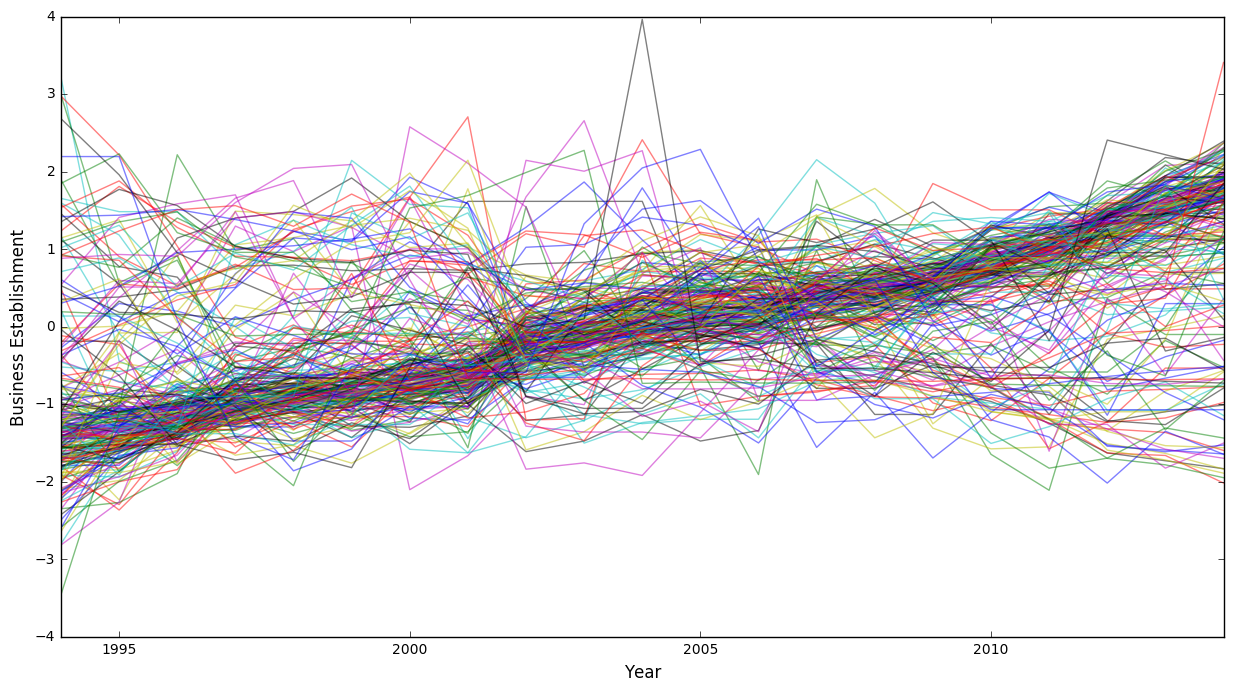

In [9]:
plt.figure(figsize=(15,8))
plt.xlim(1994,2014)

for i in range(len(nyc_shape)):
    plt.plot(nyc_shape.iloc[i, range(3,24)],alpha=0.5)
    
plt.ylabel("Business Establishment", fontsize=12)
plt.xlabel("Year", fontsize=12)

### Figure 1: Standarised Business Establishments by year
This is exploring the data visually to see and try to understand the trend. But as there are too many lines its difficult to interept any trend. Although it can be seen that there are more positive numbers than the negative. 

## Clustering the number of business establishments.

#### To determine the number of clusters lets try the 'elbow' method. 

The function definition below is from the ADS class lab. 

In [10]:
def elbow(data, K):
    '''This function is to calculate average within-cluster
    sum of squares, and plot the "elbow"
    data: dataframe of features,
    K: list of selected number of cluster'''
    
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    globals()['dist'] = [np.min(D, axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
     # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

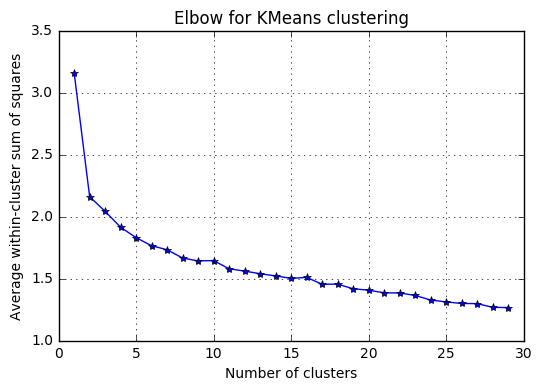

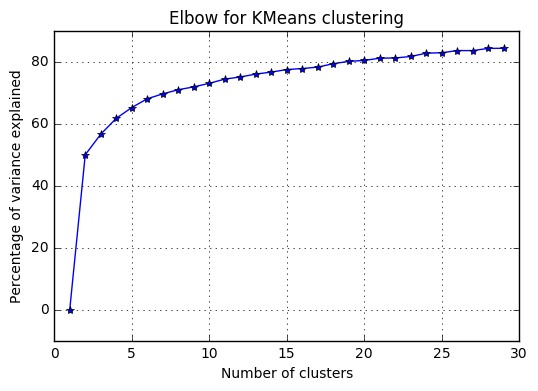

In [11]:
elbow(nyc_shape.iloc[:, range(3,24)], range(1,30))

## Figure 2: Elbow method for KMeans Clustering
It can be seen that the elbow is at 2, also the drop after 5 is gradual so we would consider something between 2 and 5 for clustering the NYC business data.

### Lets see the silhouette score for different number of clusters

In [12]:
X = nyc_shape.iloc[:, range(3,24)]
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".\
          format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.5724983348020769
For n_clusters =3, the average silhouette_score is :0.5179510293705382
For n_clusters =4, the average silhouette_score is :0.49205221674858496
For n_clusters =5, the average silhouette_score is :0.2566768917801166
For n_clusters =6, the average silhouette_score is :0.3262943866358475
For n_clusters =7, the average silhouette_score is :0.18471138526628703
For n_clusters =8, the average silhouette_score is :0.18944094128484554
For n_clusters =9, the average silhouette_score is :0.1466864828270638


Based on this two methods to find the optimum number of clusters lets conisder 5 number of clusters and continue with the KMeans clustering, as the average silhoutte score drops to half at 6 and is gradual from 2 to 5. 

## KMeans Clustering 

In [13]:
# number of clusters = 5 
nc = 5
kmeans_cluster = KMeans(n_clusters=nc, random_state=324).fit(X)
centers = kmeans_cluster.cluster_centers_
nyc_shape['km_labels'] = kmeans_cluster.labels_

Cluster Centers


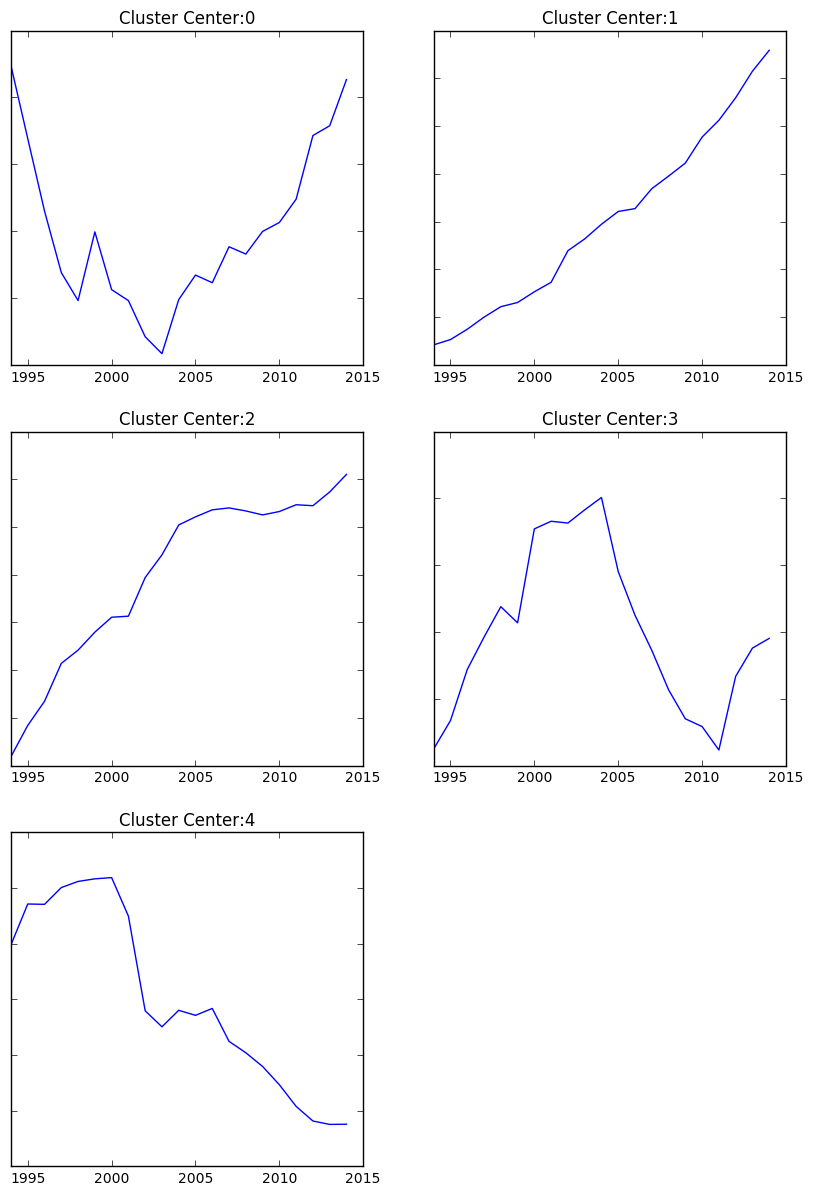

In [14]:
fig = pl.figure(figsize = (10,25))
for i,Xc in enumerate(centers):
    ax = fig.add_subplot(5,2,(i+1))
    ax.plot(years, Xc)
    pl.xticks(fontsize = 10)
    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    plt.xlim(1994,2015)
    plt.title('Cluster Center:{}'.format(i))
print ("Cluster Centers")

## Figure 3: Cluster centers for each of the 5 clusters by KMeans

It can be seen that the cluster 1 and cluster 2 show a increasing trends. Lets see the zipcodes included in each clusters.

In [15]:
# printing the zipcodes in each clusters.
for j in range(5):
    print ("zipcodes in cluster", j)
    print (nyczips[km.labels_==j])


zipcodes in cluster 0
[11040 11001 11366 11379 11221 11421 11216 11416 11233 11213 11212 11225
 11218 11226 11210 10467 10463 10468 10458 10034 10462 10453 10465 10457
 10460 10456 10472 10039 10459 10451 10027 10037 10026 10035 10029 11356
 10028 11361 11358 11362 10044 11103 11368 11355 11101 11364 10016 11109
 11367 10014 11222 10012 11211 10007 11385 11412 11251 10004 11411 11201
 11205 11208 11207 11413 11217 11231 11422 11414 11203 11220 10301 10310
 10303 11209 10305 11229 11214 10306 10153 10169 10173]
zipcodes in cluster 1
[11104 10009 10309 10111 10166 10154 10106]
zipcodes in cluster 2
[10020 10279 10171 10121]
zipcodes in cluster 3
[10024 11359 11105 10128 11363 10017 10001 11378 10006 10304 11694 10312
 10162 10175 10043 10096]
zipcodes in cluster 4
[11451 10464 11377 10018 10011 10013 11420 11215 10048 10055 10120 10278]


/Users/shalmali/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 247 but corresponding boolean dimension is 230


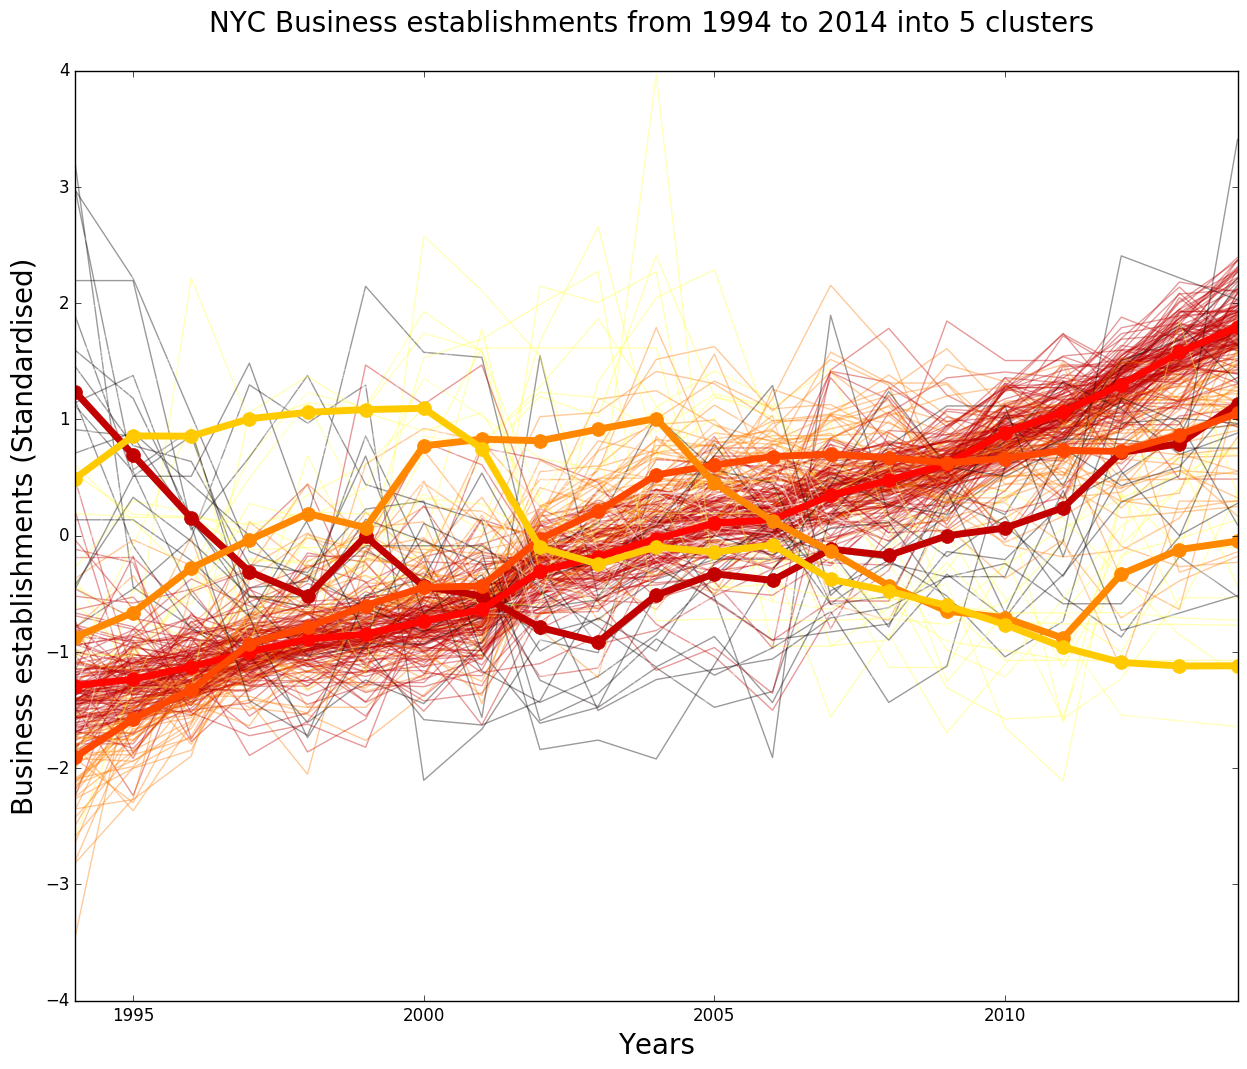

In [16]:
#Plotting timeseries of 
fig = plt.figure(figsize=(15,12))
ax = fig.gca()
for i in range(len(nyc_shape)):
    ax.plot(range(1994,2015), nyc_shape.iloc[i,range(3,24)], 
            '-', lw = 1, alpha = 0.4, c=cm.hot(nyc_shape.km_labels[i]*70) )
plt.xlim(1994,2014)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Years", fontsize=20)
plt.ylabel("Business establishments (Standardised)", fontsize=20)
plt.title('NYC Business establishments from 1994 to 2014 into 5 clusters \n', fontsize=20)
clusters = range(len(centers))
for i in range(len(centers)):
    plt.plot(range(1994,2015),centers[i],'.-', ms = 20, lw = 5, c=cm.hot(((i+1)*70 - (i*45))), \
             label = "Cluster" + str(i) )
#plt.legend(loc='best')
plt.show()

## Figure 4: Time series of all 5 clusters of Business establishments in NYC from 1994 to 2014

/Users/shalmali/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/Users/shalmali/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

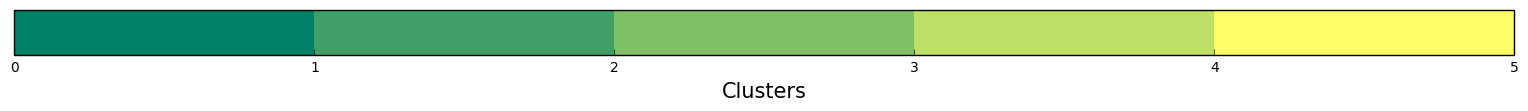

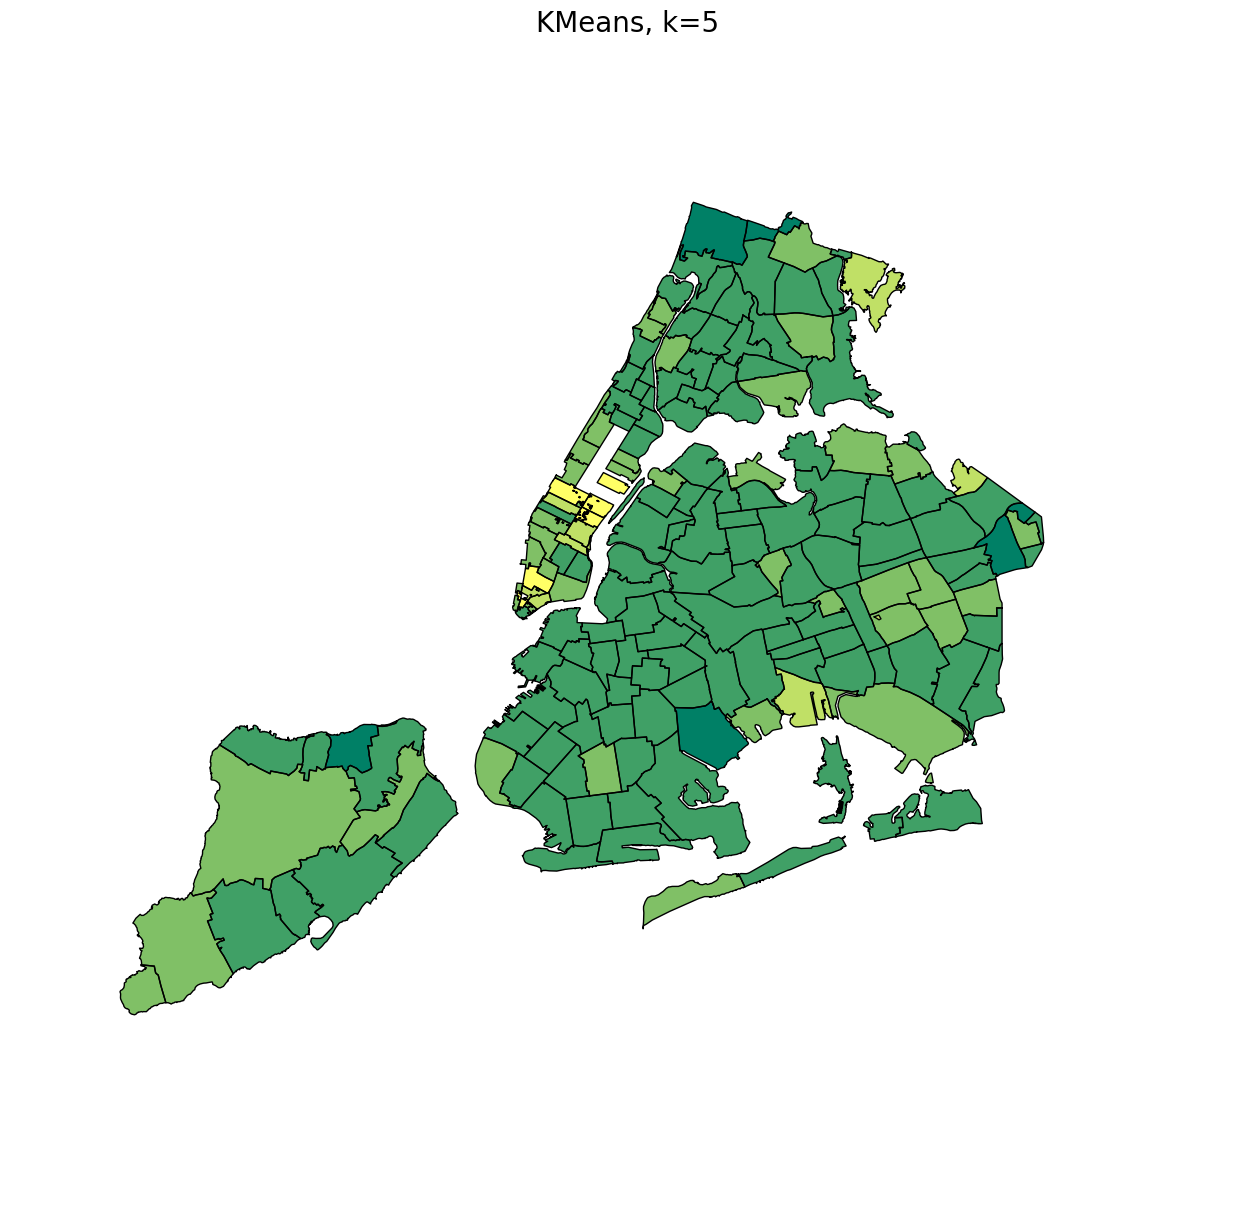

In [17]:
#Plotting KMeans clusters on map

fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.summer
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map

bounds = range(nc+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('Clusters', fontsize=15)
ax = pl.figure(figsize=(15,15)).add_subplot(111)
nyc_shape.plot(column='km_labels', colormap='summer', alpha = 1, axes=ax)
ax.set_title("KMeans, k=5", fontsize=20)
ax.axis('off')

## Figure 5: KMeans Clustering of NYC Businesses into 5 clusters
There are 2 clusters showing increasing trends, indicating economic growth which is constant for cluster 1. 

There are 2 clusters showing downward trend (cluster 3 and 4) after 2005 i.e the drop might be due to the recession. 

The choice of 5 clusters is based on the two methods - elbow and silhoutte but these two methods are not robust and dont clearly give a difinite answer for how many clusters are there in the dataset. Even the choice of 5 clusters was relatively arbitary, the clusters are fairly similar and indicates the economic growth or decline. 

## DBSCAN (Density-based spatial clustering of applications with noise) clustering technique

In [18]:
db = DBSCAN(eps=2).fit(X)
nyc_shape['db_labels'] = (db.labels_).astype(int)

In [19]:
n_clusters = len(set(nyc_shape['db_labels'])) - (1 if -1 in nyc_shape['db_labels'] else 0)
print ('Number of clusters :', n_clusters)
# printing the zipcodes in each clusters.
for j in range(n_clusters):
    print ("zipcodes in cluster", j)
    print (nyczips[db.labels_==j])
    #print ("\n")

Number of clusters : 3
zipcodes in cluster 0
[11372 11004 11040 11365 11373 11001 11375 11427 11374 11366 11423 11428
 11432 11379 11429 11435 11415 11418 11433 11221 11421 11419 11434 11216
 11416 11233 11436 11213 11212 11225 11218 11226 11219 11210 11230 11204
 10466 10467 10463 10475 10469 10468 10458 10034 10033 10462 10040 10453
 10465 10461 10457 10460 10032 10452 10456 10472 10031 10039 10459 10451
 10473 10030 10027 10474 10455 10037 10024 10454 10026 10035 10025 11357
 10029    83 11356 11359 11360 11105 10128 11371 11363 10028 11354 11102
 10021 11361 11358 11362 10044 11369 11103 11106 11368 10036 11355 11101
 11364 10001 10016 11109 10010 11367 10014 10003 11222 10002 11378 10012
 11211 10007 11385 11206 11412 10005 11251 10004 11411 11201 11205 11208
 11207 11413 11238 11231 11422 11417 11414 11232 11203 11239 11220 10301
 10310 10303 11234 10302 11693 11209 10304 10314 11228 11096 10305 11229
 11691 11223 11692 11235 10306 11224 10308 11697 10153 10169 10175 10115
 10043

/Users/shalmali/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 247 but corresponding boolean dimension is 230


/Users/shalmali/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/Users/shalmali/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

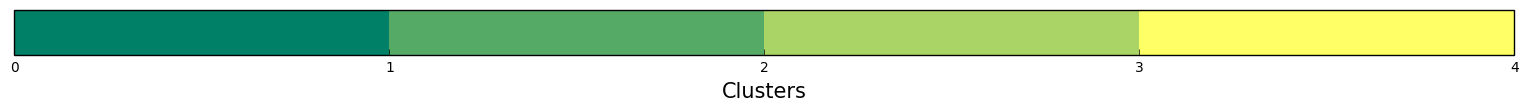

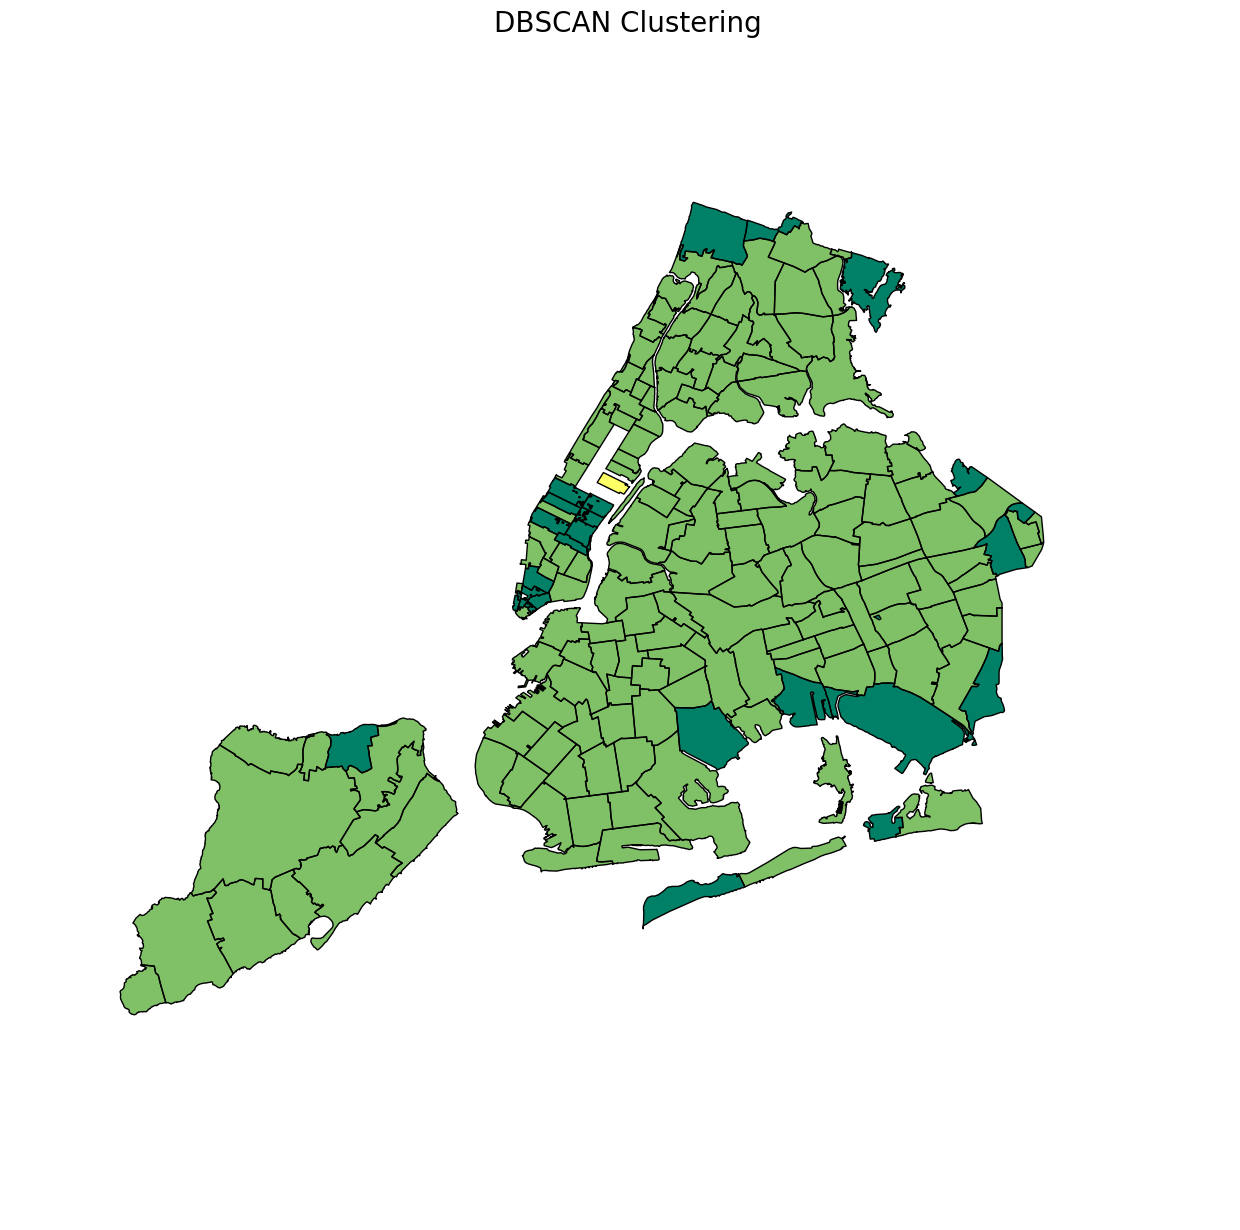

In [20]:
#Plotting DBSCAN clusters on map

fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.summer
norm = mpl.colors.Normalize(vmin=0, vmax=3)

#adding a color bar to identify the clusters on the map

bounds = range(nc)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('Clusters', fontsize=15)
ax = pl.figure(figsize=(15,15)).add_subplot(111)
nyc_shape.plot(column='db_labels', colormap='summer', alpha = 1, axes=ax)
ax.set_title("DBSCAN Clustering", fontsize=20)
ax.axis('off')

## Figure 6: DBSCAN clustering of NYC Business establishments from 1994 to 2014
Using the DBSCAN technique the dataset is clustered into 3 clusters. This technique is used to deal with noise and is robust with outliers. It can be seen that a single zipcode from Manhattan is clustered in cluster indicating a outlier. 
Staten Island and more areas of Queens are covered under clusters in DBSCAN as compared to K mean clustering

But considering the data DBscan algorithm does not perform in the best way to cluster the business data as compared to KMeans. 

## KMeans clustering number of clusters= 3

In [21]:
# number of clusters = 3 
nc = 3
kmeans_cluster3 = KMeans(n_clusters=nc, random_state=324).fit(X)
centers3 = kmeans_cluster3.cluster_centers_
nyc_shape['km_labels3'] = kmeans_cluster3.labels_

Cluster Centers


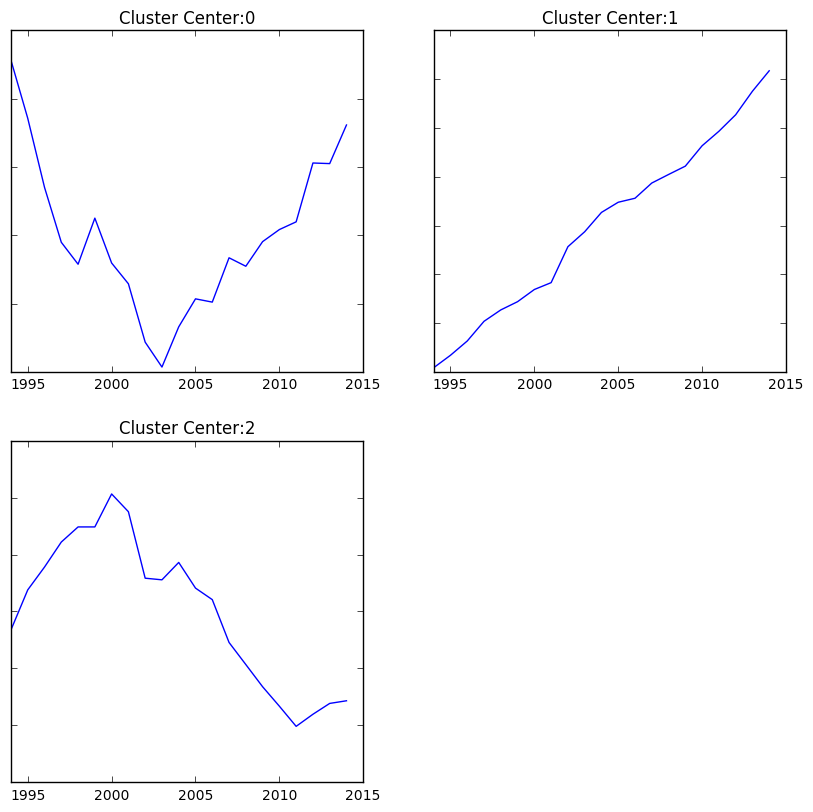

In [22]:
fig = pl.figure(figsize = (10,15))
for i,Xc in enumerate(centers3):
    ax = fig.add_subplot(3,2,(i+1))
    ax.plot(years, Xc)
    pl.xticks(fontsize = 10)
    ax.set_yticklabels([''*len(ax.get_xticklabels())])
    plt.xlim(1994,2015)
    plt.title('Cluster Center:{}'.format(i))
print ("Cluster Centers")

## Figure 7: KMeans cluster centers for K =3 

The cluster 1 shows an increasing trend while the cluster 2 shows a downward trend. 

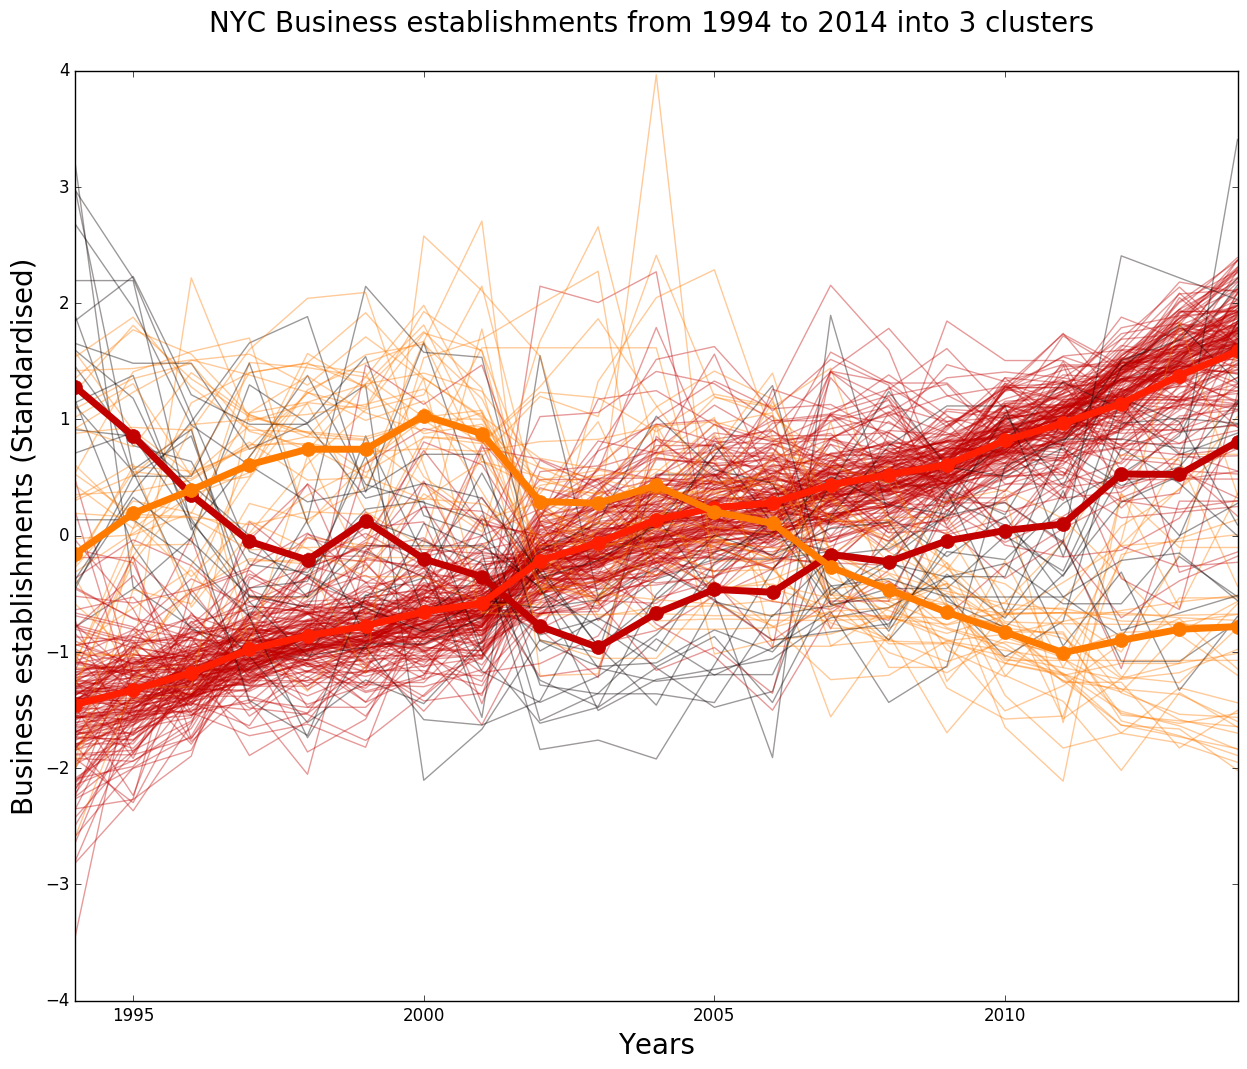

In [23]:
#Plotting timeseries of 
fig = plt.figure(figsize=(15,12))
ax = fig.gca()
for i in range(len(nyc_shape)):
    ax.plot(range(1994,2015), nyc_shape.iloc[i,range(3,24)], 
            '-', lw = 1, alpha = 0.4, c=cm.hot(nyc_shape.km_labels3[i]*70) )
plt.xlim(1994,2014)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Years", fontsize=20)
plt.ylabel("Business establishments (Standardised)", fontsize=20)
plt.title('NYC Business establishments from 1994 to 2014 into 3 clusters \n', fontsize=20)
clusters = range(len(centers3))
for i in range(len(centers3)):
    plt.plot(range(1994,2015),centers3[i],'.-', ms = 20, lw = 5, c=cm.hot(((i+1)*70 - (i*35))), \
             label = "Cluster" + str(i) )
#plt.legend(loc='best')
plt.show()

## Figure 8: Cluster centers for 3 clusters of NYC Business establishments. 

/Users/shalmali/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)
/Users/shalmali/anaconda/lib/python3.5/site-packages/geopandas/plotting.py:229: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  "(for consistency with pandas)", FutureWarning)


(-74.299999999999997,
 -73.599999999999994,
 40.400000000000006,
 41.000000000000007)

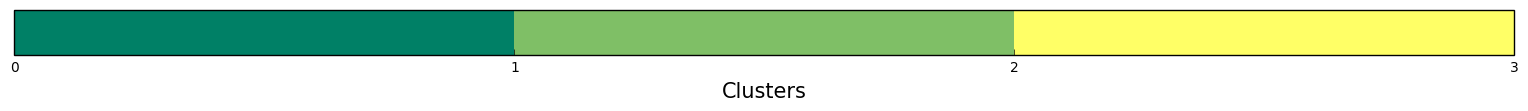

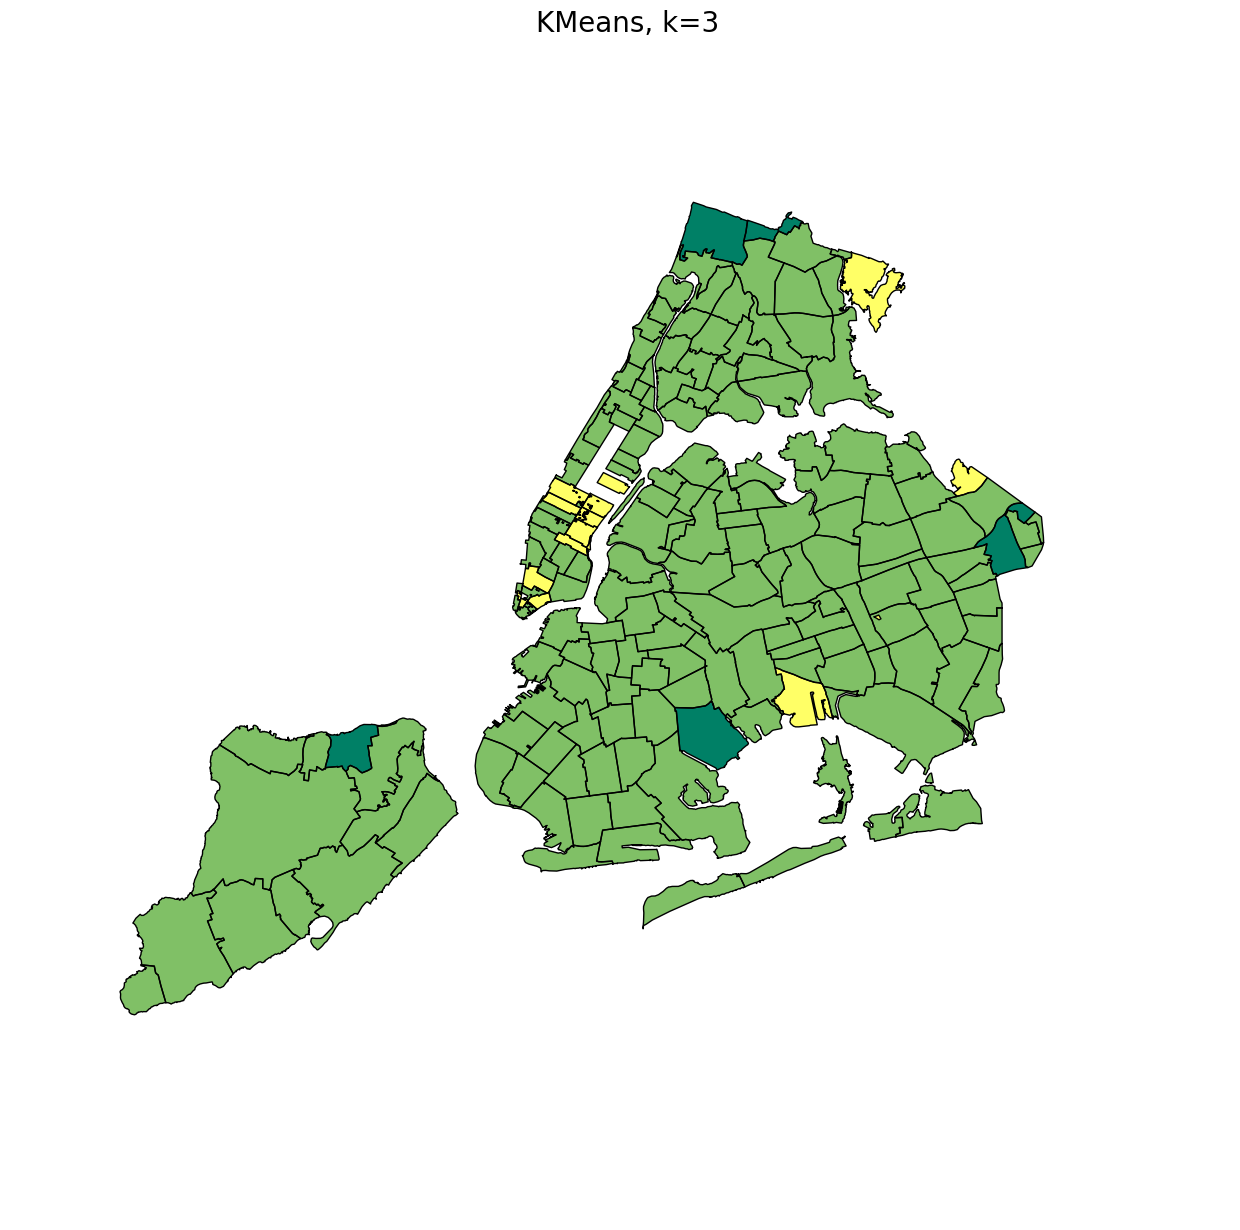

In [24]:
#Plotting KMeans clusters on map

fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.summer
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map

bounds = range(nc+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('Clusters', fontsize=15)
ax = pl.figure(figsize=(15,15)).add_subplot(111)
nyc_shape.plot(column='km_labels3', colormap='summer', alpha = 1, axes=ax)
ax.set_title("KMeans, k=3", fontsize=20)
ax.axis('off')

## Figure 9 : KMeans Clustering of NYC Businesses into 3 clusters

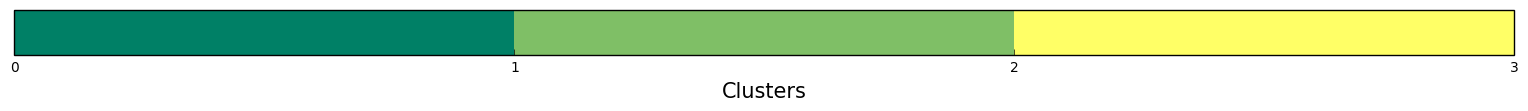

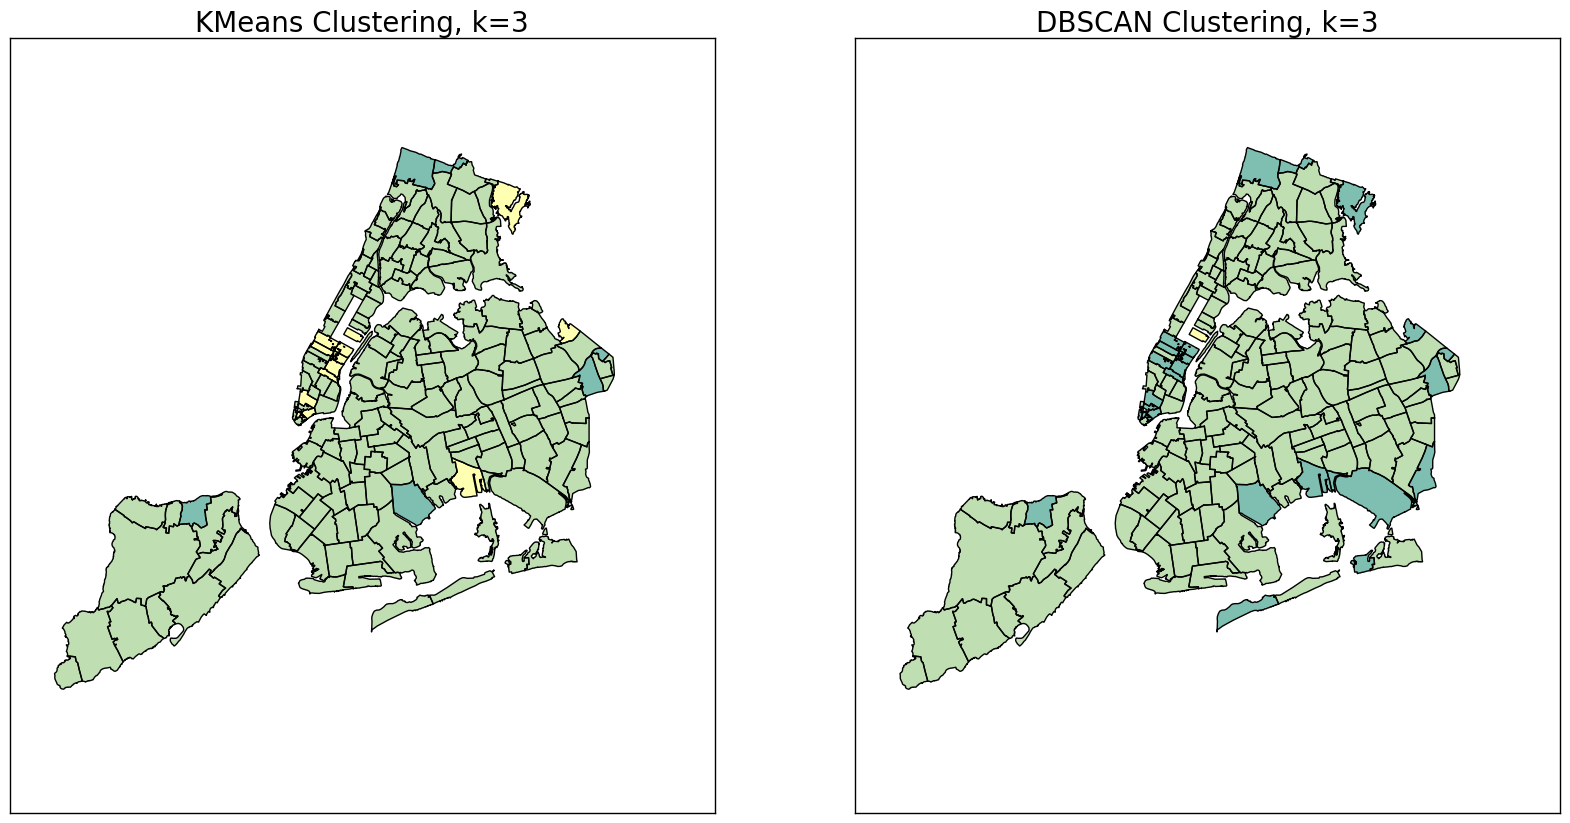

In [25]:
# comparison between Kmeans and DBSCAN number of clusters 3
fig = pl.figure(figsize=(15, 3))
ax1 = fig.add_axes([0.05, 1.0, 1, 0.15])
cmap = mpl.cm.summer
norm = mpl.colors.Normalize(vmin=0, vmax=5)

#adding a color bar to identify the clusters on the map

bounds = range(4)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                ticks=bounds,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('Clusters', fontsize=15)


fig = plt.figure(figsize=(20,10))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
nyc_shape.plot(cmap =cm.summer, column='km_labels3', ax=ax1)
ax1.set_title("KMeans Clustering, k=3", fontsize=20)
ax1.grid()
ax1.set_xticks([])
ax1.set_yticks([])

nyc_shape.plot(cmap =cm.summer, column='db_labels', ax=ax2)
ax2.set_title("DBSCAN Clustering, k=3", fontsize=20)
ax2.grid()
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

## Figure 10: Comparison between KMeans and DBSCAN clustering for 3 clusters

It can be seen that Kmeans algorithms performs better on this dataset but it depends on initial seed and the clustering would change based on initial points. Also it requires to set the number of clusters. Whereas DBSCAN requires to set the maximum distance between two samples. 
So both the algorithms requires a initial guess of parameters. 

Usually DBSCAN is used at neighborhood scale but in this case its applied on a large scale, may be thats the reason it performs differently. 

Both KMean and DBSCAN creates the same cluster in Manhattan (mainly midtown) with the most businesses, two groups with increasing businesses (one both starting with and adding more businesses), and a group with the least number of businesses that stays about the same level throughout

* Most of the city has shown in constant economic growth, as measured by the number of establishments, since 1994 (cluster 0 for 5 clusters KMeans), with a mean slope of 0.2 
* A significant fraction of zip codes suffered a slow down, since 2000 mostly these are zips in Manhattan midtown and financial district.

* Based on clustering, we noticed that the spatial difference in business growth by zip code in NYC. Especially, it indicates that through 2004 to 2013, Mid-town Manhattan went through a quite slow growth in new business establishment. 